# Distribution Lambda Layer


In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)
print(tf.config.list_physical_devices('GPU'))

TF version: 2.5.0
TFP version: 0.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Probabilistic model using the `DistributionLambda` layer

We use `DistributionLambda` layer with Bernoulli Distribution as an output layer.

Note the definition of a sigmoid function is as a following : 
$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

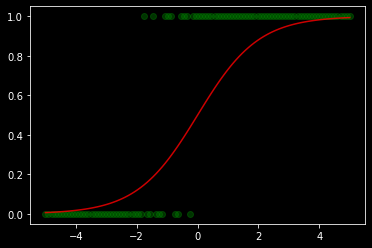

In [50]:
# Create a sigmoid model. First layer is deterministic while second layer is probabilistic
model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2),
          bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs = t), convert_to_tensor_fn = tfd.Distribution.sample)
])


x_plot = np.linspace(-5, 5, 100)
y_sigmoid = 1/(1 + np.exp(-x_plot))

# Plot Samples from our model.
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4, color='g')

# Plot Sigmoid Function
plt.plot(x_plot, y_sigmoid, color='r', alpha=0.8)
plt.show()

In [51]:
# Input for this model

x = np.array([[0]])
print("Input array x : ",x, x.shape)

# Intantiate the model class with input x

y_model = model(x)
y_model

# Predict output for input x. Repeat 5 times.

for _ in range(5):
    print(model.predict(x))


Input array x :  [[0]] (1, 1)
[[1]]
[[1]]
[[1]]
[[1]]
[[0]]


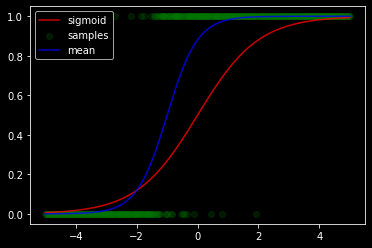

In [52]:
# Let's compare smaples and means of the probabilistic model.
# Notice the mean is somewhat off from the 'True' Sigmoid function.

# Use the model to create 500 training points
x_train = np.linspace(-5, 5, 500)[:, np.newaxis]

# Plot the Sigmoid function, the data, and the mean of the distribution.
fig, ax = plt.subplots()

# Plot the 'True' Sigmoid Function
y_train = 1/(1 + np.exp(-x_train))
plt.plot(x_plot,y_sigmoid, color='r', alpha=0.8, label = 'sigmoid')

# Plot Samples
y_model_samples = model.predict(x_train)
ax.scatter(x_train, y_model_samples, alpha=0.2, color='g', label='samples')

# Plot mean
y_model_mean = model(x_train).mean().numpy().flatten()
ax.plot(x_train, y_model_mean, 
        color='b', alpha=0.8, label='mean')

ax.legend()
plt.show()

#### Train the model with the negative loglikelihood

In [53]:
# Define negative loglikelihood, which is our loss function.

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)


# Compile using RMSprop

model.compile(loss = nll, optimizer = RMSprop(learning_rate=0.01))

In [54]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model.weights[0].numpy()[0, 0]]
training_bias = [model.weights[1].numpy()[0]]
for epoch in range(100):
    if epoch % 20 == 0:
        print("Current Epoch is :",epoch)
    model.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model.weights[0].numpy()[0, 0])
    training_bias.append(model.weights[1].numpy()[0])

Current Epoch is : 0
Current Epoch is : 20
Current Epoch is : 40
Current Epoch is : 60
Current Epoch is : 80


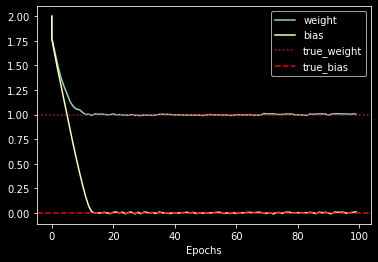

In [55]:
# Plot the model weights and biases as they train.
# Notice how the weight and bias converges.

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='r', linestyle=':')
plt.axhline(y=0, label='true_bias', color='r', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()